# Baseline

We establish a strong baseline in this notebook with:
- Local Outlier Factor (LOF),
- One-Class SVM,
- Isolation Forest,
- Autoencoder.

We chose the MNIST dataset for this benchmark, excluding the digit *9* from the training data: *9* shall be considered the anomalous data.

In [2]:
import os

import numpy as np
np.random.seed(0)
np.set_printoptions(suppress=True)

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import fetch_mldata
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pandas as pd

import time
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
mnist = fetch_mldata('MNIST original', data_home='.', )
mnist.data = mnist.data.astype(np.float32)
mnist.data = (mnist.data - np.mean(mnist.data)) / np.std(mnist.data)

In [35]:
X_random = np.random.uniform(size=(500, 784))

### 1. 4's and 7's
The training data consists of 500 4's as normal data that we contaminate by 10 7's. The evaluation data consits of 4000 4's and 80 7's.

In [360]:
ntest_normal = 4000
fours = mnist.data[mnist.target == 4]
sevens = mnist.data[mnist.target == 0]
idx = np.random.choice(range(fours.shape[0]), size=5000, replace=False)
fours = fours[idx]
idx = np.random.choice(range(sevens.shape[0]), size=90, replace=False)
sevens = sevens[idx]
# X_train = np.concatenate([fours[:500], sevens[:10]])
X_train = fours[:1000]
Y_train = np.array([0] * 500 + [1] * 10)
X_test = np.concatenate([fours[1000:], sevens[10:]])
Y_test = np.array([0] * ntest_normal + [1] * 80)

### 7's and full MNIST

Use 50% of training data exlcuding 7 for training and the rest for evaluation.

In [4]:
# X = mnist.data[mnist.target != 7]
# Y = mnist.target[mnist.target != 7]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
# X_anomalies_full = mnist.data[mnist.target == 7]

# X_random = np.random.uniform(size=(10000, 784))

Subsample the anomalies.

In [4]:
# rate = .05
# size = np.min((int(rate * X_train.shape[0]), X_anomalies_full.shape[0]))
# idx = np.random.choice(range(X_anomalies_full.shape[0]), size=size, replace=False)
# X_anomalies = X_anomalies_full[idx]

Some dimensionality reduction.

In [110]:
from sklearn import decomposition

In [361]:
pca30 = decomposition.PCA(n_components=30)
mnist_pca30 = pca30.fit_transform(X_test)

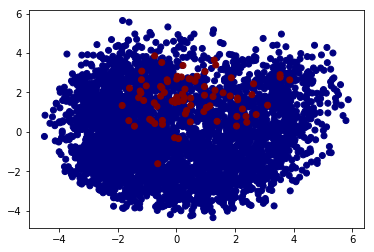

In [362]:
plt.scatter(*zip(*mnist_pca30[:, :2]), c=Y_test, cmap='jet')

Some helper functions.

In [238]:
def calc_pr(scores, labels, plot=False):
    """
    Given scores and labels, returns the precision, recall, thresholds and
    area under the curve.
    
    Params:
        scores      (1d-numpy array): low scores should represent anomalies.
        labels      (1d-numpy array): same shape as `score`, `1` is for anonaly,
                                      `0` for normal data.
        plot                  (bool): if `True`, plots the precision-recall curve.
    
    Returns:
        precision, recall, thresholds, area under the curve
    """
    if scores.ndim != 1:
        raise ValueError('`scores` has %i dimensions instead of 1.' % scores.ndim)
    if not isinstance(scores, np.ndarray):
        scores = np.array(scores)
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    
    idx = np.argsort(scores)
    ascores = scores[idx]
    alabels = labels[idx]
    tps = np.cumsum(alabels).astype(np.float32)
    fps = np.arange(tps.shape[0]) + 1. - tps
    recall = tps / np.sum(alabels)
    precision = np.divide(tps, tps + fps, out=np.zeros_like(tps), where=(tps + fps)!=0.)
    auc = np.trapz(precision, recall)
    
    if plot:
        plot_pr(precision, recall, auc)
    return precision, recall, ascores, auc


def plot_pr(precision, recall, auc=None):
    plt.plot(recall, precision)
    plt.ylim((0., 1.1))
    plt.xlim((0., 1.1))
    plt.ylabel('precision')
    plt.xlabel('recall');
    plt.title('Precision-Recall curve (AUC = %s)\n' % ('%.3f' % auc if auc else 'N/A'), size=14)
    plt.show

## 1. Isolation Forest

In [363]:
iforest = IsolationForest(contamination=.0, n_estimators=500,n_jobs=-1)

In [364]:
iforest.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.0, max_features=1.0,
        max_samples='auto', n_estimators=500, n_jobs=-1, random_state=None,
        verbose=0)

In [365]:
y_pred_test = iforest.decision_function(X_test)
#y_pred_anomalies = iforest.decision_function(X_anomalies)
y_pred_random = iforest.decision_function(X_random)

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


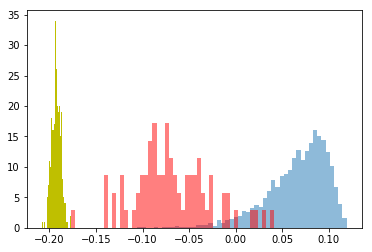

In [366]:
plt.hist(y_pred_test[:ntest_normal], bins=50, normed=True, alpha=.5)
plt.hist(y_pred_test[ntest_normal:], bins=50, color='red', normed=True, alpha=.5);
# plt.hist(y_pred_anomalies, bins=50, color='red', normed=False, alpha=.5)
plt.hist(y_pred_random, bins=50, color='y');

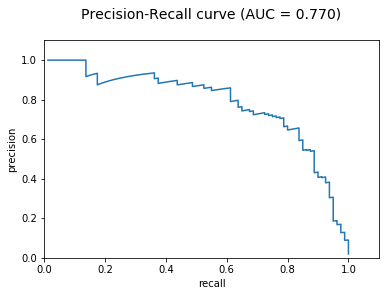

In [367]:
# scores = np.concatenate([y_pred_anomalies, y_pred_test])
# labels = np.array([1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0])
scores = y_pred_test
labels = Y_test
p, r, t, auc = calc_pr(scores, labels)
plot_pr(p, r, auc)

The results are pretty bad. Let's use PCA on the data beforehand.

In [368]:
varE = [.1, .2, .3, .4, .5, .6, .7, .85, .9, .95, .98, .99, .9999999, 1.]
aucs = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    
    # Isolation Forest
    iforest = IsolationForest(contamination=.0, n_jobs=-1, n_estimators=500)
    iforest.fit(X_train_pca)
#     X_test_pca, X_anomalies_pca = pca.transform(X_test), pca.transform(X_anomalies)
    X_test_pca = pca.transform(X_test)
    y_pred_test = iforest.decision_function(X_test_pca)
#     y_pred_anomalies = iforest.decision_function(X_anomalies_pca)
#     scores = np.concatenate([y_pred_anomalies, y_pred_test])
#     labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
    scores = y_pred_test
    labels = Y_test

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

********************
 explained variance = 0.10 - n components = 1
AUC = 0.017
********************
 explained variance = 0.20 - n components = 2
AUC = 0.015
********************
 explained variance = 0.30 - n components = 4
AUC = 0.013
********************
 explained variance = 0.40 - n components = 6
AUC = 0.016
********************
 explained variance = 0.50 - n components = 8
AUC = 0.018
********************
 explained variance = 0.60 - n components = 12
AUC = 0.094
********************
 explained variance = 0.70 - n components = 19
AUC = 0.110
********************
 explained variance = 0.85 - n components = 46
AUC = 0.808
********************
 explained variance = 0.90 - n components = 69
AUC = 0.908
********************
 explained variance = 0.95 - n components = 119
AUC = 0.935
********************
 explained variance = 0.98 - n components = 193
AUC = 0.930
********************
 explained variance = 0.99 - n components = 248
AUC = 0.932
********************
 explained variance =

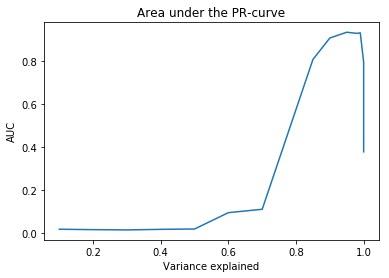

In [369]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


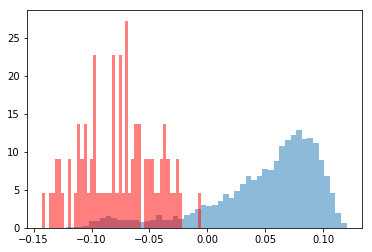

In [370]:
# plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
# plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);
plt.hist(y_pred_test[:ntest_normal], bins=50, normed=True, alpha=.5);
plt.hist(y_pred_test[ntest_normal:], bins=50, color='red', normed=True, alpha=.5);

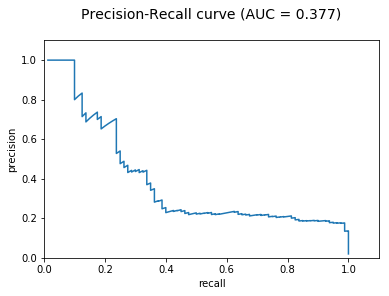

In [371]:
plot_pr(p, r, auc)

## 2. Local Outlier Factor

In [248]:
from sklearn.neighbors import LocalOutlierFactor

In [372]:
pca = decomposition.PCA(.8)
X_pca = pca.fit_transform(X_train)
# A_pca = pca.transform(X_anomalies)
Xt_pca = pca.transform(X_test)

In [373]:
lof = LocalOutlierFactor(contamination=0.001)
lof.fit(X_pca)

LocalOutlierFactor(algorithm='auto', contamination=0.001, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=20,
          p=2)

In [374]:
# A_lof = lof._decision_function(A_pca)
X_lof = lof._decision_function(Xt_pca)

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


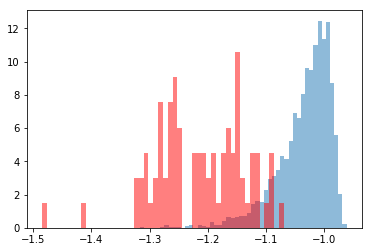

In [375]:
# plt.hist(X_lof, bins=50, alpha=.5);
# plt.hist(A_lof, bins=50, color='red', alpha=.5);
plt.hist(X_lof[:ntest_normal], bins=50, alpha=.5, normed=True);
plt.hist(X_lof[ntest_normal:], bins=50, color='red', alpha=.5, normed=True);

In [145]:
# scores = np.concatenate([A_lof, X_lof])
# labels = np.array([1] * A_lof.shape[0] + [0] * X_lof.shape[0])
# p, r, t, auc = calc_pr(scores, labels)
# plot_pr(p, r, auc)

In [376]:
varE = [.1, .2, .3, .4, .5, .6, .7, .8, .82, .85, .9, .95, .99, 1.]
aucs = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    #X_train_pca = pca.transform(X_train)
    
    # Isolation Forest
    localOut = LocalOutlierFactor(contamination=.001)
    localOut.fit(X_train_pca)
#     X_test_pca, X_anomalies_pca = pca.transform(X_test), pca.transform(X_anomalies)
    X_test_pca = pca.transform(X_test)
    y_pred_test = localOut._decision_function(X_test_pca)
#     y_pred_anomalies = localOut._decision_function(X_anomalies_pca)    
    
    
#     scores = np.concatenate([y_pred_anomalies, y_pred_test])
#     labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
    scores = y_pred_test
    labels = Y_test

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

********************
 explained variance = 0.10 - n components = 1
AUC = 0.021
********************
 explained variance = 0.20 - n components = 2
AUC = 0.017
********************
 explained variance = 0.30 - n components = 4
AUC = 0.021
********************
 explained variance = 0.40 - n components = 6
AUC = 0.035
********************
 explained variance = 0.50 - n components = 8
AUC = 0.046
********************
 explained variance = 0.60 - n components = 12
AUC = 0.181
********************
 explained variance = 0.70 - n components = 19
AUC = 0.172
********************
 explained variance = 0.80 - n components = 33
AUC = 0.596
********************
 explained variance = 0.82 - n components = 37
AUC = 0.706
********************
 explained variance = 0.85 - n components = 46
AUC = 0.857
********************
 explained variance = 0.90 - n components = 69
AUC = 0.934
********************
 explained variance = 0.95 - n components = 119
AUC = 0.950
********************
 explained variance = 0

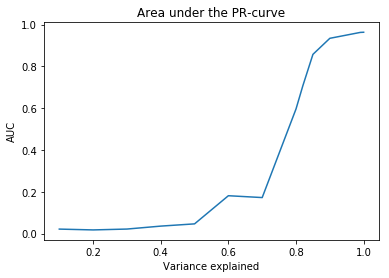

In [377]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


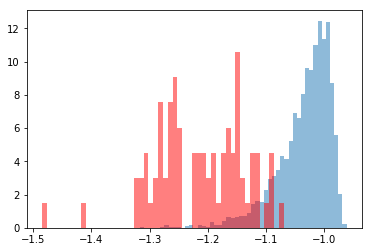

In [378]:
# plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
# plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);
plt.hist(X_lof[:ntest_normal], bins=50, alpha=.5, normed=True);
plt.hist(X_lof[ntest_normal:], bins=50, color='red', alpha=.5, normed=True);

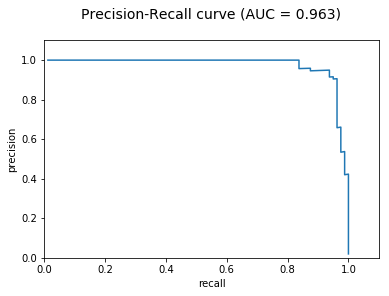

In [379]:
p, r, t, auc = calc_pr(scores, labels, plot=True)

## 3. One-class SVM

In [257]:
from sklearn.svm import OneClassSVM

In [380]:
#svm = OneClassSVM(nu=.01)
svm = OneClassSVM()

In [381]:
pca = decomposition.PCA(.5)
X_pca = pca.fit_transform(X_train)
# A_pca = pca.transform(X_anomalies)
Xt_pca = pca.transform(X_test)
R_pca = pca.transform(X_random)

In [382]:
svm.fit(X_pca)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [383]:
# A_svm = svm.decision_function(A_pca)
Xt_svm = svm.decision_function(Xt_pca)
R_svm = svm.decision_function(R_pca)

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


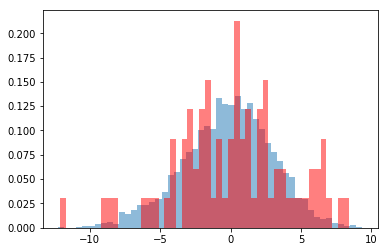

In [384]:
normed = True
plt.hist(Xt_svm[:ntest_normal], bins=50, normed=normed, alpha=.5);
plt.hist(Xt_svm[ntest_normal:], bins=50, normed=normed, color='red', alpha=.5);
# plt.hist(R_svm, bins=50, normed=normed, color='y', alpha=.5);

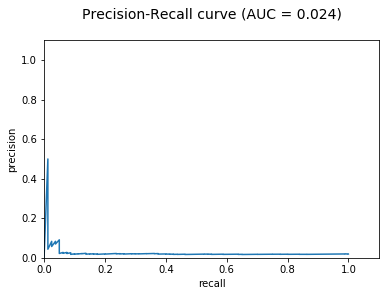

In [385]:
# scores = np.concatenate([A_svm, Xt_svm])[:, 0]
# labels = np.array([1] * A_svm.shape[0] + [0] * Xt_svm.shape[0])
scores = Xt_svm[:, 0]
labels = Y_test
p, r, t, auc = calc_pr(scores, labels)
plot_pr(p, r, auc)

In [386]:
varE = [.1, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, 1.]
aucs = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    #X_train_pca = pca.transform(X_train)
    
    # Isolation Forest
    svm = OneClassSVM(nu=.01)
    svm.fit(X_train_pca)
#     X_test_pca, X_anomalies_pca = pca.transform(X_test), pca.transform(X_anomalies)
    X_test_pca = pca.transform(X_test)

    y_pred_test = svm.decision_function(X_test_pca)
#     y_pred_anomalies = svm.decision_function(X_anomalies_pca)
    
#     scores = np.concatenate([y_pred_anomalies, y_pred_test])[:, 0]
#     labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
    scores = y_pred_test[:, 0]
    labels = Y_test

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

********************
(1000, 1)
 explained variance = 0.10 - n components = 1
AUC = 0.022
********************
(1000, 2)
 explained variance = 0.20 - n components = 2
AUC = 0.028
********************
(1000, 4)
 explained variance = 0.30 - n components = 4
AUC = 0.036
********************
(1000, 6)
 explained variance = 0.40 - n components = 6
AUC = 0.018
********************
(1000, 8)
 explained variance = 0.50 - n components = 8
AUC = 0.014
********************
(1000, 12)
 explained variance = 0.60 - n components = 12
AUC = 0.047
********************
(1000, 19)
 explained variance = 0.70 - n components = 19
AUC = 0.029
********************
(1000, 33)
 explained variance = 0.80 - n components = 33
AUC = 0.200
********************
(1000, 46)
 explained variance = 0.85 - n components = 46
AUC = 0.560
********************
(1000, 69)
 explained variance = 0.90 - n components = 69
AUC = 0.785
********************
(1000, 119)
 explained variance = 0.95 - n components = 119
AUC = 0.847
*******

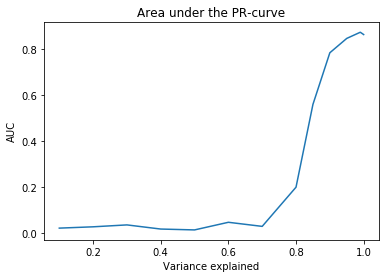

In [387]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


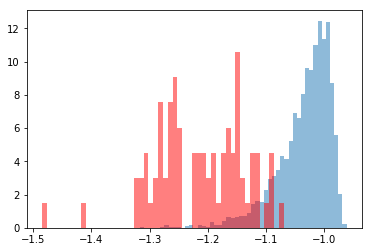

In [388]:
plt.hist(X_lof[:ntest_normal], bins=50, alpha=.5, normed=True);
plt.hist(X_lof[ntest_normal:], bins=50, color='red', alpha=.5, normed=True);

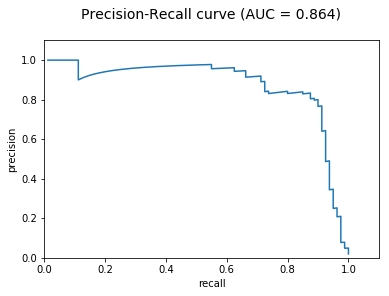

In [389]:
p, r, t, auc = calc_pr(scores, labels, plot=True)

## 4. Autoencoder

In [390]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
from utils import progress, count_parameters, visualize, get_batch

cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on CPU


In [164]:
# mnist = fetch_mldata('MNIST original', data_home='.', )
# mnist.data = mnist.data.astype(np.float32)
# mnist.data = mnist.data / 255.

In [165]:
# ntest_normal = 4000
# fours = mnist.data[mnist.target == 4]
# sevens = mnist.data[mnist.target == 7]
# idx = np.random.choice(range(fours.shape[0]), size=4500, replace=False)
# fours = fours[idx]
# idx = np.random.choice(range(sevens.shape[0]), size=90, replace=False)
# sevens = sevens[idx]
# # X_train = np.concatenate([fours[:500], sevens[:10]])
# X_train = fours[:500]
# Y_train = np.array([0] * 500 + [1] * 10)
# X_test = np.concatenate([fours[500:], sevens[10:]])
# Y_test = np.array([0] * ntest_normal + [1] * 80)

In [10]:
# X = mnist.data[mnist.target != 7]
# Y = mnist.target[mnist.target != 7]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
# X_anomalies_full = mnist.data[mnist.target == 7]

# X_random = np.random.uniform(size=(10000, 784))

# rate = .05
# size = np.min((int(rate * X_train.shape[0]), X_anomalies_full.shape[0]))
# idx = np.random.choice(range(X_anomalies_full.shape[0]), size=size, replace=False)
# X_anomalies = X_anomalies_full[idx]

In [391]:
pca = decomposition.PCA()
X_pca = pca.fit_transform(X_train)
# A_pca = pca.transform(X_anomalies)
Xt_pca = pca.transform(X_test)
R_pca = pca.transform(X_random)

In [392]:
n_dim = X_pca.shape[1]
# n_dim = 28*28
print(n_dim)

784


In [393]:
def tonumpy(x):
    return x.data.cpu().numpy()


def evaluate(net, data, shape, norm='fro'):
    shape = tuple([-1] + shape)
    output = []
    for j, x in enumerate(get_batch(data, batch_size, allow_smaller_batch=True)):
        xt = Variable(torch.from_numpy(x).type(FloatTensor))
        xt = xt.view(shape)
        output.append(np.linalg.norm(x.reshape(-1, np.prod(shape[1:])) - net(xt).data.cpu().numpy().reshape((-1, np.prod(shape[1:]))), axis=1, ord=norm))
    return np.concatenate(output)

In [415]:
z = 64
net2 = nn.Sequential(
                # Encoder
                nn.Linear(n_dim, 16),
                nn.ReLU(),
                nn.BatchNorm1d(16),
                nn.Linear(16, 16),
                nn.ReLU(),
                nn.BatchNorm1d(16),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
    
                # Low-dimensional representation
                nn.Linear(16, z),
                nn.ReLU(),
                nn.BatchNorm1d(z),
    
                # Decoder
                nn.Linear(z, 16),
                nn.ReLU(),
                nn.BatchNorm1d(16),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.Linear(128, 128),
#                 nn.ReLU(),
#                 nn.BatchNorm1d(128),
                nn.Linear(16, 16),
                nn.BatchNorm1d(16),
                nn.ReLU(),
                nn.Linear(16, n_dim)).type(FloatTensor)
#                 nn.Sigmoid()).type(FloatTensor)
count_parameters(net2)
optimizer = torch.optim.Adamax(params=net2.parameters(), lr=0.01)

28,816 parameters
28,816 trainable parameters


In [488]:
# z = 1 # default=8
# net2  = nn.Sequential(
#                 # Encoder
#                 nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
#                 nn.PReLU(32),
#                 nn.BatchNorm2d(32),
#                 nn.MaxPool2d(2), # (32, 14, 14)
#                 nn.Conv2d(32, 64, 3), # (64, 12, 12)
#                 nn.PReLU(64),
#                 nn.BatchNorm2d(64),
#                 nn.MaxPool2d(2), # (64, 6, 6))
                
#                 # Low-dimensional representation
#                 nn.Conv2d(64, z, 3), # (8, 4, 4) -- latent representation
#                 nn.PReLU(z),
#                 nn.BatchNorm2d(z),
                
#                 # Decoder
#                 nn.Conv2d(z, 64, 3, padding=2), # (64, 6, 6)
#                 nn.Upsample(scale_factor=2), # (64, 12, 12)
#                 nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
#                 nn.PReLU(32),
#                 nn.Upsample(scale_factor=2), # (32, 28, 28)
#                 nn.Conv2d(32, 1, 3, padding=1),
#                 nn.Sigmoid()).type(FloatTensor).type(FloatTensor)
# count_parameters(net2)
# optimizer = torch.optim.Adam(params=net2.parameters(), lr=0.01)

In [416]:
max_epochs = 100
batch_size = 32
N = X_train.shape[0]
# optimizer.param_groups[0]['lr'] = 0.01
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    net2.train()
    for j, x in enumerate(get_batch(X_train, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor))
        x = x.view(x.size(0), -1)
        #x = x.view((-1, 1, 28, 28))
        net2.zero_grad()
        x_ = net2(x)
        loss = torch.dist(x, x_) 
        #loss = torch.nn.BCELoss()(x_, x) * batch_size
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net2, mnist.data[:55000], in_size=[28*28])
    else:
        if i % 20 == 0 and i != 0:
            optimizer.param_groups[0]['lr'] /= 2.
#             print(optimizer.param_groups[0]['lr'])
            
        shape = [n_dim]
        norm = None
        net2.eval()
        y_pred_test = evaluate(net2, X_test, shape, norm=norm)
#         y_pred_anomalies = evaluate(net2, A_pca, shape, norm=norm)

        mean_normal = np.mean(y_pred_test[:ntest_normal])
        mean_anomaly = np.mean(y_pred_test[ntest_normal:])

#         mean_anomaly = np.mean(y_pred_anomalies)
#         scores = -np.concatenate([y_pred_anomalies, y_pred_test])
        scores = -y_pred_test
        labels = Y_test

#         labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
        p, r, t, auc = calc_pr(scores, labels)
        print('\x1b[31m%.3f - auc = %.3f\x1b[0m' % (mean_anomaly / mean_normal, auc))


[  1/100][==================================================] 100% – loss 42.79055 -    0s [6064 fps]
0.982 - auc = 0.018
[  2/100][==================================================] 100% – loss 34.34675 -    0s [5354 fps]
0.995 - auc = 0.019
[  3/100][==================================================] 100% – loss 33.24749 -    0s [4401 fps]
0.981 - auc = 0.018
[  4/100][==================================================] 100% – loss 32.49493 -    0s [6334 fps]
0.993 - auc = 0.019
[  5/100][==================================================] 100% – loss 31.72554 -    0s [4300 fps]
1.007 - auc = 0.020
[  6/100][==================================================] 100% – loss 30.90589 -    0s [6003 fps]
0.941 - auc = 0.015
[  7/100][==================================================] 100% – loss 30.21478 -    0s [6841 fps]
1.012 - auc = 0.022
[  8/100][==================================================] 100% – loss 29.49672 -    0s [5899 fps]
0.974 - auc = 0.018
[  9/100][==============

KeyboardInterrupt: 

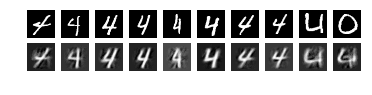

In [411]:
net2.eval()
visualize(net2, X_test, in_size=[28*28], dtype=FloatTensor)

In [412]:
# shape = [1, 28, 28]
shape = [n_dim]
norm = None
net2.eval()
y_pred_test = evaluate(net2, X_test, shape, norm=norm)
# y_pred_anomalies = evaluate(net2, A_pca, shape, norm=norm)

mean_normal = np.mean(y_pred_test[:ntest_normal])
mean_normal = np.mean(y_pred_test[ntest_normal:])
# mean_anomaly = np.mean(y_pred_anomalies)
print(mean_normal, mean_anomaly, mean_anomaly / mean_normal)

3.4530702 3.6455789 1.05575


In [242]:
# visualize(net2, X_pca, in_size=[1, 28*28], dtype=FloatTensor)

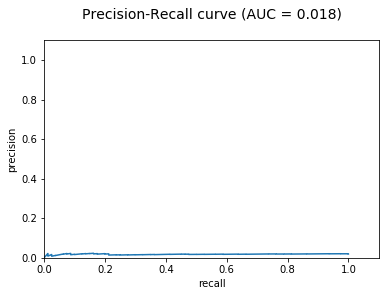

In [413]:
# scores = -np.concatenate([y_pred_anomalies, y_pred_test])

# labels = [1] * y_pred_anomalies.shape[0] + [0] * y_pred_test.shape[0]
scores = -y_pred_test
labels = Y_test
p, r, t, auc = calc_pr(scores, labels, plot=True)

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


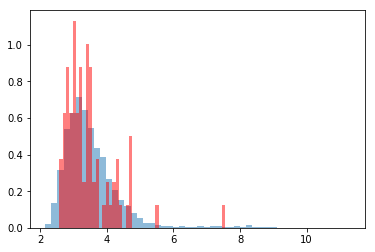

In [414]:
# plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
# plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);
plt.hist(y_pred_test[:ntest_normal], bins=50, normed=True, alpha=.5);
plt.hist(y_pred_test[ntest_normal:], bins=50, color='red', normed=True, alpha=.5);